In [1]:
"""combined bw saccader with color drift nwk"""
#from image_env_mnist1 import Image_env1
from RL_saccader_x1 import DeepQNetwork
from RL_networks import Stand_alone_net
import numpy as np
import time
import pickle
import copy
import SYCLOP_env as syc
from misc import *
import sys
import os
import tensorflow as tf
import cv2
import json

hp=HP()
# if not os.path.exists(hp.this_run_path):
#     os.makedirs(hp.this_run_path)
# else:
#     error('run name already exists!')

hp.save_path = 'saved_runs'
hp.this_run_name = 'DELETEME_nb_' + '_noname_' + str(int(time.time()))
# hp.description = "only 2nd image from videos 1st frame, penalty for speed, soft q learning"
hp.description = "cnn on stills from movies, changed tau_int"
hp.mem_depth = 1
hp.max_episode = 1000
hp.steps_per_episode = 1000
hp.steps_between_learnings = 100
hp.steps_before_learning_begins = 100
hp.fading_mem = 0.0
hp.tau_int=4
hp.saccade_observation_scale = 100
hp.num_images = 200
recorder_file = 'records.pkl'
hp_file = 'hp.pkl'
hp.contrast_range = [1.0,1.1]
hp.dqn_initial_network = None # 'saved_runs/run_syclop_generic_cnn_vfb_neu.py_noname_1590422112_0/tempX_1.nwk'  # None #'saved_runs/run_syclop_generic_cnn_vfb_neu.py_noname_1589383850_0/tempX_1.nwk'
hp.grayscale = False
hp.saccade_initial_network='saved_runs/run_saccader301.py_noname__1617839305_319150_1//tempX_saccade.nwk'

hp.drift_initial_network= 'saved_runs/run_saccader301.py_noname__1617839305_319150_1/tempX_drift.nwk'# 'saved_runs/run_saccader201.py_noname__try_resize_tau4__1616409975_993559_1/tempX_drift.nwk'  
nchannels = 1 if hp.grayscale else 3
if not os.path.exists(hp.save_path):
    os.makedirs(hp.save_path)

dir_success = False
for sfx in range(1):  # todo legacy
    candidate_path = hp.save_path + '/' + hp.this_run_name + '_' + str(os.getpid()) + '/'
    if not os.path.exists(candidate_path):
        hp.this_run_path = candidate_path
        os.makedirs(hp.this_run_path)
        dir_success = True
        break
if not dir_success:
    error('run name already exists!')
def deploy_logs():
    sys.stdout = Logger(hp.this_run_path+'log.log')
    print('results are in:', hp.this_run_path)
    print('description: ', hp.description)
    print('hyper-parameters (partial):', hp)

def local_observer(sensor,agent,integrator):
    normfactor=1.0/256.0
    return np.concatenate([normfactor*sensor.dvs_view.reshape([-1]), agent.qdot, integrator.reshape([-1])],axis=0)

def saccade_observer(sensor,drift_observation):
    normfactor=1.0/256.0
    return np.concatenate([normfactor*sensor.frame_view.mean(axis=2).reshape([-1]), drift_observation.reshape([-1])],axis=0)

def drift_state_for_saccade_observation(current_state, integrator_state):
    return integrator_state

def drift_state_for_integrator(drift_net_state, abs_en=False,layer=-2):
    if abs_en:
        return np.abs(drift_net_state[layer])
    else:
        return drift_net_state[layer]

def index_to_coord(i,xymax,offset=[0,0]):
    return [i%xymax[0]+offset[0],-(i//xymax[0]+offset[1])]

# def undistort_q_poly(dq,w,cm=None):
#     if cm is None:
#         cm = np.array([[0,0]])
#     xy = dq-cm
#     r = np.sqrt(np.sum(xy**2,axis=1))
#     powvec = np.array([list(range(len(w)))])
#     rnew = (r[..., np.newaxis]**powvec) @ w
#     xynew = xy *(rnew / r)[..., np.newaxis]
#     dqnew = xynew + cm
#     return dqnew

In [2]:
def label_from_filename(filename):
    label=''.join([uu+'_' for uu in filename.split('/')[-1].split('_')[:-1]])
    label=label[:-1]
    return label

In [3]:
with open('fisheye_102.pkl','rb') as f:
    fy_dict=pickle.load(f)

In [4]:
# if __name__ == "__main__":
recorder = Recorder(n=6)

#     images = read_images_from_path('/home/bnapp/arivkindNet/video_datasets/stills_from_videos/some100img_from20bn/*',max_image=hp.num_images)
images = prep_mnist_sparse_images(10,images_per_scene=20)
# images = read_images_from_path('/home/labs/ahissarlab/arivkind/video_datasets/stills_from_videos/some100img_from20bn/*',max_image=hp.num_images)

# with open('../video_datasets/liron_images/shuffled_images.pkl', 'rb') as f:
#     images = pickle.load(f)
print(len(images))
scene = syc.Scene(frame_list=images)
sensor = syc.Sensor( fisheye=fy_dict,centralwinx=32,centralwiny=32,nchannels=nchannels)
saccade_agent = syc.Saccadic_Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

reward = syc.Rewards(reward_types=['network'],relative_weights=[100.0])
# observation_size = sensor.hp.winx*sensor.hp.winy*2
# saccade_observation_size = 64*64*nchannels+200
saccade_observation_size = 64*64*1+200
# n_features_shaped = list(np.shape(sensor.dvs_view))
# if len(n_features_shaped)<3: # to support 2 and 3d dvs views
#     n_features_shaped.append(nchannels) 

# saccade_RL = DeepQNetwork(np.prod(saccade_agent.max_q), saccade_observation_size,
saccade_RL=DeepQNetwork(64*64, saccade_observation_size,
                  n_features_shaped=[64,64,1],#n_features_shaped,
                  shape_fun= None,
                  reward_decay=0.99,
                  replace_target_iter=10,
                  memory_size=10000,
                  e_greedy_increment=0.0001,
                  learning_rate=0.0025,
                  double_q=True,
                  dqn_mode=True,
                  soft_q_type='boltzmann',
                  beta_schedule=[[1, 10]],#[[4000, 0.1], [7000, 1.0]],
                  arch='conv_saccades_v1',
                   n_modulating_features=200      
                  )
# at this point drift network is a standalone network taken from some external source (e.g. pretrained)
# in future it will be an action generating network from the drift loop
# drift_net =  Stand_alone_net([32,32,nchannels],10,arch='conv',
#                                     layer_size = [None]+[[3,3,32]]+[[2,2,16]]+[200]+[ None],
#                                     loss_type='softmax_cross_entropy',
#                                     trainable=True,
#                                     lr=0.0005,
#                                     lambda_reg=0.0)
drift_net = Stand_alone_net([32,32,3],10,arch='conv', 
                                    layer_size = [None]+[[5,5,96],[5,5,80],[5,5,64],[5,5,64]]+[200]+[ None],
                                    loss_type='softmax_cross_entropy',
                                    trainable=True,
                                    lr=1,
                                    dropout_p_keep=0.99,
                                    lambda_reg=0.0)
#simple cifar10 classifier
drift_net.assign_session_to_nwk(saccade_RL.dqn.sess)
saccade_RL.dqn.sess.run(tf.global_variables_initializer())
saccade_RL.dqn.reset()
#     if not(hp.dqn_initial_network is None):
saccade_RL.dqn.load_nwk_param(hp.saccade_initial_network)
drift_net.load_nwk_param(hp.drift_initial_network)
hp.scene = scene.hp
hp.sensor = sensor.hp
hp.saccade_agent = saccade_agent.hp
hp.reward = reward.hp
hp.saccade_RL = saccade_RL.hp
#     deploy_logs()
#     with open(hp.this_run_path+hp_file, 'wb') as f:
#         pickle.dump(hp, f)
#     run_env()
#     print('results are in:', hp.this_run_path)

10
debug n_features: [64, 64, 1]
debu: [64, 64, 32]
debudebu layer_shape: (?, 64, 64, 32)
debu: [64, 64, 32]
debug: (?, 200)
debug: (?, 30)
debug: (?, 32)
debudebu layer_shape: (?, 64, 64, 32)
debu: [64, 64, 1]
debudebu layer_shape: (?, 64, 64, 1)
debug n_features: [64, 64, 1]
debu: [64, 64, 32]
debudebu layer_shape: (?, 64, 64, 32)
debu: [64, 64, 32]
debug: (?, 200)
debug: (?, 30)
debug: (?, 32)
debudebu layer_shape: (?, 64, 64, 32)
debu: [64, 64, 1]
debudebu layer_shape: (?, 64, 64, 1)
debug SESSSS!!!!
debug SESSSS!!!!
debug n_features: [32, 32, 3]
debu: [32, 32, 96]
debu: [16, 16, 80]
debu: [8, 8, 64]
debu: [4, 4, 64]
debug: (?, 256)
debug: (?, 200)
debug SESSSS!!!!


In [25]:
def run_saccade_loop(image,steps,debug=False):
    saccade_observation = 0*np.random.uniform(0,1,size=[hp.mem_depth, saccade_observation_size])
    scene=syc.Scene(image_matrix = image)
#     print('debuu-----',scene.image.shape,'-----',np.shape(sensor.dvs_view))
    integrator_state = 0
    saccade_action=64*32+32
    saccade_agent.reset(
    q_reset=np.array([100,100]),
    max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])


    local_q_recorder=[]
    local_driftstate_recorder=[]
    local_integrator_recorder=[]
#     saccade_agent.reset(q_reset=[np.random.randint(saccade_agent.max_q[0]+1),
#                                  np.random.randint(saccade_agent.max_q[1]+1)])
    saccade_agent.reset(q_reset=[saccade_agent.max_q[0]//2,
                             saccade_agent.max_q[1]//2])
    for step_prime in range(steps):

        local_q_recorder.append(0+saccade_agent.q)

        drift_net_state = drift_net.eval_incl_layers(1./256 *sensor.central_frame_view.reshape([1,32,32,nchannels])) #todo - change to some integrated version of the DVS view when adding the drift loop
        high_pass_layer = drift_state_for_integrator(drift_net_state) - integrator_state
        integrator_state = (1-1./hp.tau_int)*integrator_state+(1./hp.tau_int)*drift_state_for_integrator(drift_net_state)
        reward.update_rewards(sensor=sensor, agent=saccade_agent, network=high_pass_layer)
        saccade_RL.store_transition(saccade_observation.reshape([-1]), saccade_action, reward.reward)
        saccade_observation = hp.saccade_observation_scale*saccade_observer(sensor,
                                               drift_state_for_saccade_observation(drift_net_state,integrator_state))
        saccade_action, ent = saccade_RL.choose_action(saccade_observation.reshape([-1]),
                                                       discard_black_areas=True, 
                                                       black_area=(sensor.frame_view.max(axis=2)>1e-9))

        local_driftstate_recorder.append(0.+drift_state_for_integrator(drift_net_state))
        local_integrator_recorder.append(0.+integrator_state)

#         running_ave_reward = 0.999*running_ave_reward+0.001*np.array([reward.reward]+reward.rewards.tolist())
        # print('testing printout: reward:',reward.reward,' coord' ,saccade_agent.q,'\n')
        dq = index_to_coord(saccade_action,sensor.frame_view.shape,offset=[-31,-31])
        dq_rescaled = undistort_q_poly(dq,fy_dict['w']).squeeze().astype(np.int64)
#         print(index_to_coord(saccade_action,sensor.frame_view.shape,offset=[-31,-31]),dq,dq_rescaled)

        saccade_agent.act(dq_rescaled)
    #         print('----',saccade_agent.q)
        uu = saccade_observation[np.newaxis, :]

        sensor.update(scene,saccade_agent)
        if debug:
            plt.figure()
            plt.imshow(sensor.frame_view,cmap='gray')
    return local_q_recorder, local_driftstate_recorder,local_integrator_recorder      



In [6]:
sf_path = '/home/bnapp/datasets/Stanford40/JPEGImages/*'
label_counter={}
filenames = sorted(glob.glob(sf_path))
for filename in filenames:
    label=label_from_filename(filename)
    if label not in label_counter.keys():
        label_counter[label] = 1
    else:
        label_counter[label] += 1

In [7]:
db_dir='saccade_ds_fy_fy2_CIFAR201colorMixRe0p5_tau4_20stp'
if not os.path.exists(db_dir):
        os.makedirs(db_dir)
        os.makedirs(db_dir+'/DATA/')
        os.makedirs(db_dir+'/META/') 

debuu----- (264, 214, 3) ----- (64, 64, 3)


/home/bnapp/arivkindNet/rlnet1/RL_saccader_x1.py:178: RuntimeWarning: divide by zero encountered in log
  entropy = np.sum(-boltzmann_measure*np.log(boltzmann_measure))
/home/bnapp/arivkindNet/rlnet1/RL_saccader_x1.py:178: RuntimeWarning: invalid value encountered in multiply
  entropy = np.sum(-boltzmann_measure*np.log(boltzmann_measure))


debuu----- (214, 274, 3) ----- (64, 64, 3)
debuu----- (214, 297, 3) ----- (64, 64, 3)
debuu----- (272, 214, 3) ----- (64, 64, 3)
debuu----- (289, 214, 3) ----- (64, 64, 3)
debuu----- (264, 331, 3) ----- (64, 64, 3)
debuu----- (264, 269, 3) ----- (64, 64, 3)
debuu----- (214, 289, 3) ----- (64, 64, 3)
debuu----- (164, 197, 3) ----- (64, 64, 3)
debuu----- (202, 164, 3) ----- (64, 64, 3)
debuu----- (464, 364, 3) ----- (64, 64, 3)


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (282, 214, 3) ----- (64, 64, 3)
debuu----- (214, 288, 3) ----- (64, 64, 3)
debuu----- (164, 215, 3) ----- (64, 64, 3)
debuu----- (164, 242, 3) ----- (64, 64, 3)
debuu----- (264, 364, 3) ----- (64, 64, 3)
debuu----- (214, 264, 3) ----- (64, 64, 3)
debuu----- (264, 363, 3) ----- (64, 64, 3)
debuu----- (264, 270, 3) ----- (64, 64, 3)
debuu----- (266, 214, 3) ----- (64, 64, 3)
debuu----- (214, 238, 3) ----- (64, 64, 3)


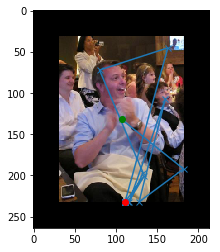

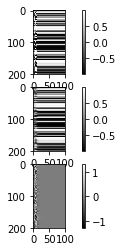

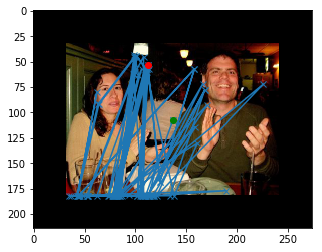

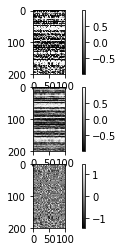

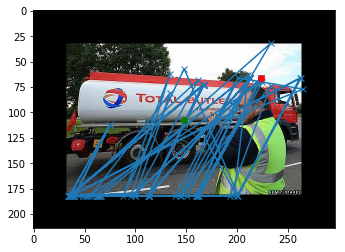

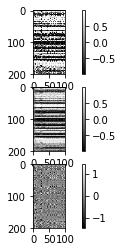

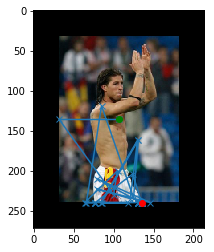

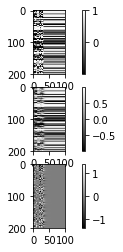

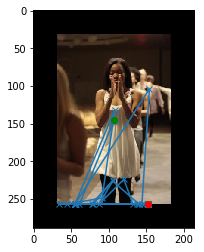

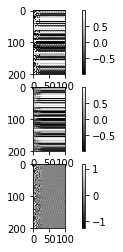

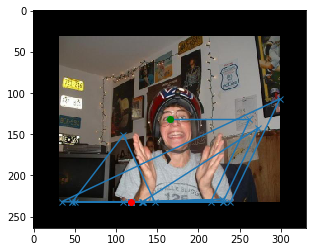

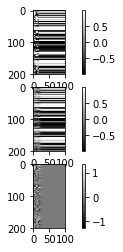

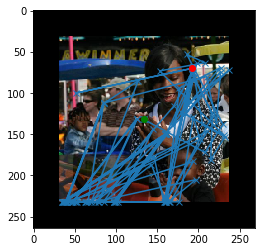

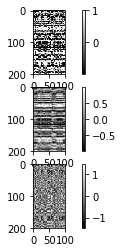

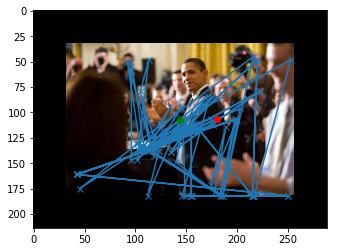

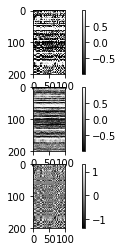

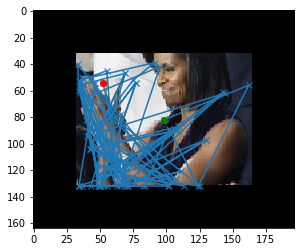

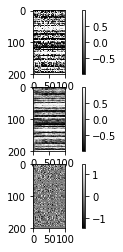

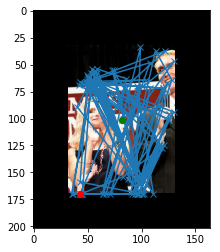

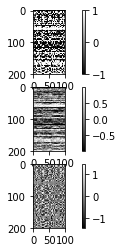

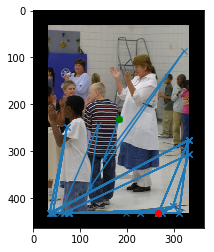

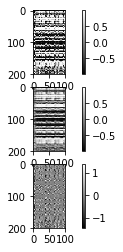

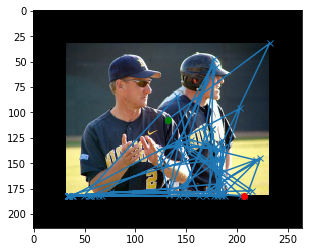

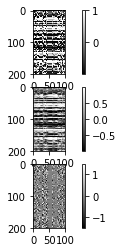

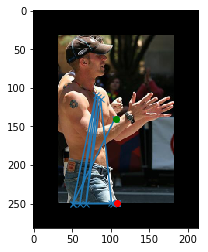

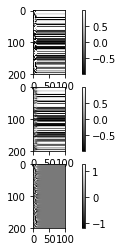

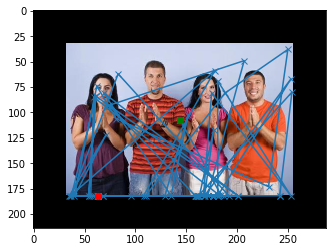

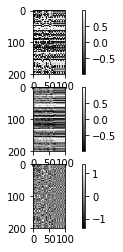

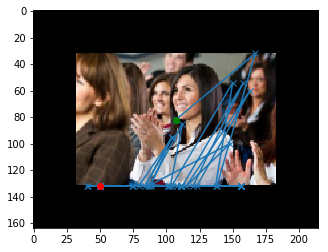

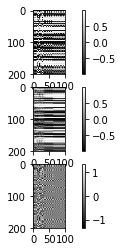

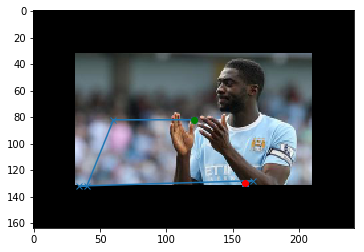

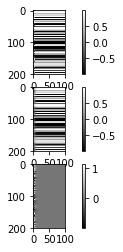

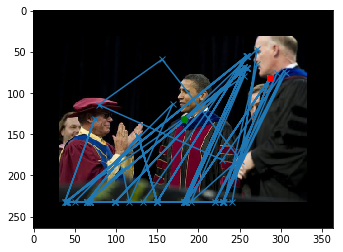

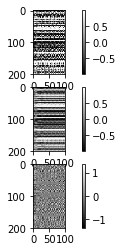

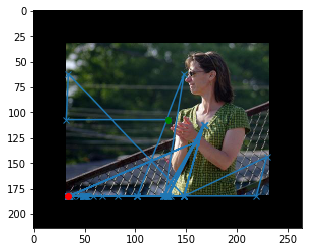

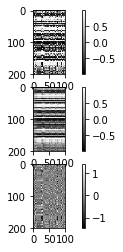

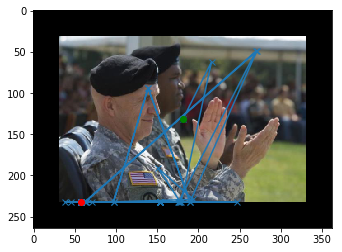

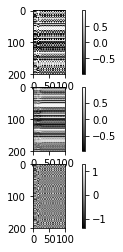

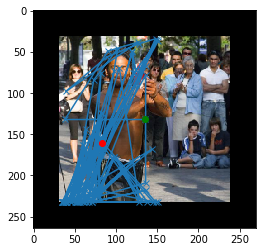

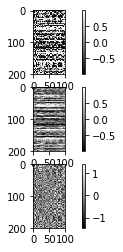

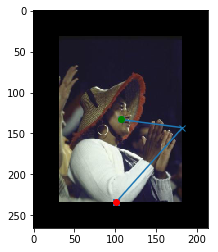

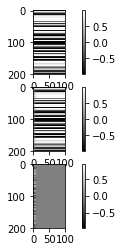

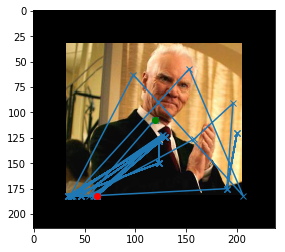

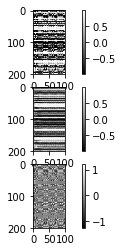

In [8]:
for ii,filename in enumerate(filenames):
    image,_ = read_random_image_from_path(filename, grayscale=hp.grayscale, padding=[32,32],resize=0.5)
#     image,_ = read_random_image_from_path(filename, grayscale=hp.grayscale, padding=None,resize=0.5)

    local_q_recorder, local_driftstate_recorder,local_integrator_recorder = run_saccade_loop(image,100)
    plt.figure()
    plt.imshow(image/256.)
    qqnp=np.array(local_q_recorder)
    maxy=image.shape[0]
    plt.plot(32+qqnp[:,0],maxy-32-qqnp[:,1],'x-')
    plt.plot(32+qqnp[0,0],maxy-32-qqnp[0,1],'go')
    plt.plot(32+qqnp[-1,0],maxy-32-qqnp[-1,1],'ro')
    
    drift_state=np.array(local_driftstate_recorder).squeeze()
    integrated_drift_state=np.array(local_integrator_recorder).squeeze()
    high_pass_drift_state=drift_state - integrated_drift_state
    plt.figure()
    plt.subplot(3,1,1)
    plt.imshow(drift_state.transpose(),cmap='gray')
    plt.colorbar()
    plt.subplot(3,1,2)
    plt.imshow(integrated_drift_state.transpose(),cmap='gray')
    plt.colorbar()

    plt.subplot(3,1,3)
    plt.imshow(high_pass_drift_state.transpose(),cmap='gray')
    plt.colorbar()

    if ii>20:
        break

In [9]:
label_to_num={l:ii for ii,l in enumerate(sorted(label_counter.keys()))}

In [26]:
#differences instead of absolute locations ~42% accuracy - just a bit above the no location setting
n_glimpse=20
mock_location=False
labels={'standard':{}}
for ii,filename in enumerate(filenames):
    image,_ = read_random_image_from_path(filename, grayscale=hp.grayscale, padding=[32,32],resize=0.5)
    if len(image.shape)==2:
        image = np.repeat(image[...,np.newaxis],3,axis=2)
        print('bum')
    local_q_recorder, local_driftstate_recorder,local_integrator_recorder = run_saccade_loop(image,n_glimpse)
    if mock_location:
        local_q_recorder = np.random.normal(size=np.shape(local_q_recorder))
    uu2=[np.reshape(uu,[np.shape(uu)[0],1,-1]) for uu in [local_q_recorder, local_driftstate_recorder,local_integrator_recorder]]
    data=np.concatenate(uu2,axis=2)
    np.save(db_dir+'/DATA/{}.npy'.format(str(ii)),
           data.transpose([0,2,1]))
#     strtpt_=strtpt*1.0
    labels['standard'][str(ii)]=label_to_num[label_from_filename(filename)]
#     if ii>20:
#         break
    if not ii%100:
        print(ii)

/home/bnapp/arivkindNet/rlnet1/RL_saccader_x1.py:178: RuntimeWarning: divide by zero encountered in log
  entropy = np.sum(-boltzmann_measure*np.log(boltzmann_measure))
/home/bnapp/arivkindNet/rlnet1/RL_saccader_x1.py:178: RuntimeWarning: invalid value encountered in multiply
  entropy = np.sum(-boltzmann_measure*np.log(boltzmann_measure))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
bum
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500


In [27]:
with open(db_dir+'/META/labels.json', 'w') as outfile:
    json.dump(labels, outfile)

In [11]:
image.shape

(214, 264)

In [12]:
ii

2376

In [15]:
uu=np.repeat(image[...,np.newaxis],3,axis=2)

In [16]:
uu.shape

(214, 264, 3)

In [23]:
uu[100,105], image[100,105]

(array([72.25, 72.25, 72.25]), 72.25)

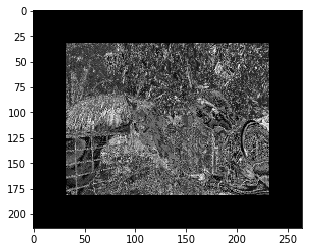

In [24]:
plt.figure()
plt.imshow(uu/256.)